## LSTM Classifier

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext.legacy as tt
import seaborn as sns

from tqdm.notebook import tqdm

## Data Preparation

In [2]:
# to reproduce same results
SEED = 1234

# torch
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  

In [3]:
# define TEXT, LABEL and fields
TEXT = tt.data.Field(tokenize='spacy', batch_first=True, include_lengths=True)
LABEL = tt.data.LabelField(dtype = torch.long, batch_first=True)

fields = [('label', LABEL), ('text',TEXT)]

In [4]:
# load dataset
training_data = tt.data.TabularDataset(path='preprocessed.csv', format='csv', fields = fields, skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))

# create train and test splits
train_data, test_data = training_data.split(split_ratio=0.8, random_state=random.seed(SEED))

# initialize glove embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data) 

{'label': 'Clothing', 'text': ['key', 'features', 'alisha', 'solid', 'womens', 'cycling', 'shorts', 'cotton', 'lycra', 'navy', 'red', 'navyspecifications', 'alisha', 'solid', 'womens', 'cycling', 'shorts', 'shorts', 'details', 'number', 'contents', 'sales', 'package', 'pack', 'fabric', 'cotton', 'lycra', 'type', 'cycling', 'shorts', 'general', 'details', 'pattern', 'solid', 'ideal', 'womens', 'fabric', 'care', 'gentle', 'machine', 'wash', 'lukewarm', 'water', 'bleach', 'additional', 'details', 'style', 'code', 'althtp', 'box', 'shorts']}


In [5]:
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# set batch size
BATCH_SIZE = 128

# load an iterator
train_iterator, test_iterator = tt.data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [6]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        """
        Initialise LSTM classifier. Define the layers required.
        
        Args:
            vocab_size: Size of vocabulary
            embedding_dim: Size of embeddings
            hidden_dim: Number of features in hidden state of LSTM
            output_dim: Number of features in outpu
            n_layers: Number of LSTM layers
            bidirectional: Directionality of LSTM layers
            dropout: Dropout probability
        """

        super().__init__()          
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        """
        Forward pass for LSTM layer.
        
        Args:
            text: input string (description in this case)
            text_lengths: length of text (required for packing)
            
        """
        # text = [batch size, text length]

        embedded = self.embedding(text)
        # embedded = [batch size, text length, embed dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [batch size, num layers * num directions, hidden dim]
        # cell = [batch size, num layers * num directions, hidden dim]
        
        # concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        # hidden = [batch size, hidden dim * num directions]
        outputs = self.linear(hidden)
        
        return outputs

In [7]:
# hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 64
num_output_nodes = 15
num_layers = 3
bidirection = True
dropout = 0.2

# instantiate the model
model = LSTMClassifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

# model architecture
print(model)

LSTMClassifier(
  (embedding): Embedding(10546, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (linear): Linear(in_features=128, out_features=15, bias=True)
)


In [8]:
# initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

torch.Size([10546, 100])


In [9]:
# optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#define metric
def accuracy(y_pred, y_test):
    y_pred_soft = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_label = torch.max(y_pred_soft, dim = 1)    
    
    correct_pred = (y_pred_label == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    
    return acc
    
accuracy_stats = {
    'train': [],
    'test': []
}

loss_stats = {
    'train': [],
    'test': []
}

# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [10]:
def train(model, iterator, optimizer, criterion):
    # initialize for every epoch
    epoch_loss = 0
    epoch_acc = 0
    
    # model training phase
    model.train()  
    
    for batch in iterator:
        # reset the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and text length
        text, text_lengths = batch.text   
        
        # convert output of model to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        # compute loss and accuracy
        loss = criterion(predictions, batch.label)
        acc = accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
def evaluate(model, iterator, criterion):
    # initialize for every epoch
    epoch_loss = 0
    epoch_acc = 0

    # model eval phase (dropout layers are not used)
    model.eval()
    
    # deactivate gradient computatiom
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and text length
            text, text_lengths = batch.text
            
            # convert output of model to 1D tensor
            predictions = model(text, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            
            # loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
EPOCHS = 25
best_loss = float('inf')

for e in tqdm(range(1, EPOCHS+1)):
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    
    loss_stats['train'].append(train_loss)
    loss_stats['test'].append(test_loss)
    accuracy_stats['train'].append(train_acc)
    accuracy_stats['test'].append(test_acc)

    # save the best model
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f}')
    print(f'Train Acc: {train_acc:.3f}| Test Acc: {test_acc:.3f}')

Epoch 001: | Train Loss: 1.68051 | Test Loss: 1.16408
Train Acc: 50.923| Test Acc: 61.267
Epoch 002: | Train Loss: 0.84045 | Test Loss: 0.53868
Train Acc: 73.103| Test Acc: 82.833
Epoch 003: | Train Loss: 0.38259 | Test Loss: 0.31172
Train Acc: 89.051| Test Acc: 90.900
Epoch 004: | Train Loss: 0.19802 | Test Loss: 0.18090
Train Acc: 94.624| Test Acc: 95.167
Epoch 005: | Train Loss: 0.12573 | Test Loss: 0.17088
Train Acc: 96.650| Test Acc: 94.900
Epoch 006: | Train Loss: 0.09236 | Test Loss: 0.13192
Train Acc: 97.504| Test Acc: 96.333
Epoch 007: | Train Loss: 0.07876 | Test Loss: 0.12335
Train Acc: 97.897| Test Acc: 96.167
Epoch 008: | Train Loss: 0.05513 | Test Loss: 0.11222
Train Acc: 98.479| Test Acc: 96.933
Epoch 009: | Train Loss: 0.06176 | Test Loss: 0.11318
Train Acc: 98.154| Test Acc: 96.733
Epoch 010: | Train Loss: 0.04342 | Test Loss: 0.10854
Train Acc: 98.761| Test Acc: 97.267
Epoch 011: | Train Loss: 0.03263 | Test Loss: 0.11337
Train Acc: 99.077| Test Acc: 97.033
Epoch 012:

Text(0.5, 1.0, 'Train-Test Loss/Epoch')

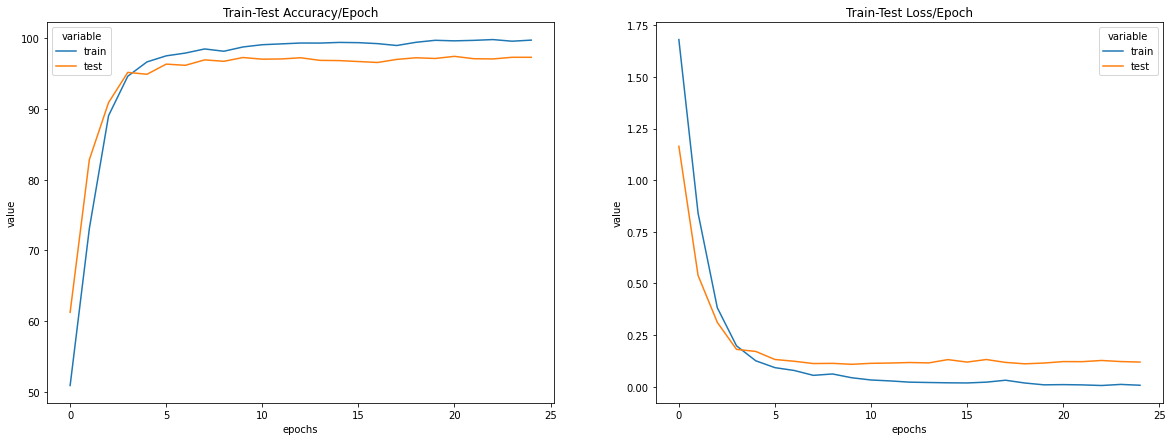

In [13]:
# create dataframes
train_test_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_test_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_test_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Test Accuracy/Epoch')
sns.lineplot(data=train_test_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Test Loss/Epoch')